#### Imports

In [1]:
import cv2
from pathlib import Path
from omegaconf import OmegaConf
import torch
import numpy as np
import wandb
from hydra import initialize, compose
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import wandb
from datetime import datetime
import matplotlib.pyplot as plt 



In [2]:
import sys
import os
from pathlib import Path

def get_project_root():
    # Detectar si estamos en Jupyter Notebook
    if '__file__' not in globals():
        # Notebook → os.getcwd() ES la raíz del proyecto
        return Path(os.getcwd()).resolve()
    else:
        # Script → __file__ está en la raíz del proyecto
        return Path(__file__).resolve().parent

project_root = get_project_root()
sys.path.insert(0, str(project_root))

print("Project root:", project_root)
print("Contenido:", os.listdir(project_root))

Project root: C:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\ProyectoAnomalias
Contenido: ['.git', '.gitignore', '.vscode', 'anomalias.ipynb', 'checkpoints', 'conf', 'Images', 'logs', 'src', 'train_model.py', '__pycache__']


### Se toman las 10 carpetas (cable, capsule, grid, hazelnut, leather, metal_nut, pill, screw, tile, transistor) y se separa su información de testing training y se juntan en un solo dataset, igualmente guardando las etiquetas y se setea el tamaño de cada imagen en 128x128

In [3]:
import cv2
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ============================================================================
# CONFIGURACIÓN
# ============================================================================
DATASETS = [
    'cable', 'capsule', 'grid', 'hazelnut', 'leather', 
    'metal_nut', 'pill', 'screw', 'tile', 'transistor'
]

BASE_PATH = Path('./Images')
OUTPUT_PATH = BASE_PATH / 'DATASET_128x128'
IMAGE_SIZE = (128, 128)

# SPLIT: 80% train, 20% validation (de las imágenes 'good')
TRAIN_VAL_SPLIT = 0.8
RANDOM_SEED = 42

# ============================================================================
# CREAR ESTRUCTURA DE SALIDA (CON VALIDACIÓN)
# ============================================================================
print("Creando estructura de carpetas...")
for split in ['train', 'validation', 'test', 'ground_truth']:
    (OUTPUT_PATH / split).mkdir(parents=True, exist_ok=True)
print("✓ Estructura creada\n")

# ============================================================================
# FUNCIÓN DE PROCESAMIENTO
# ============================================================================
def process_and_save(src_path: Path, dest_dir: Path, prefix: str, is_mask=False):
    """Lee, redimensiona y guarda imagen."""
    try:
        img = cv2.imread(str(src_path), cv2.IMREAD_UNCHANGED)
        if img is None:
            return False
        
        interp = cv2.INTER_NEAREST if is_mask else cv2.INTER_AREA
        resized = cv2.resize(img, IMAGE_SIZE, interpolation=interp)
        
        dest = dest_dir / f"{prefix}_{src_path.stem}{src_path.suffix}"
        cv2.imwrite(str(dest), resized)
        return True
    
    except Exception as e:
        print(f"Error con {src_path.name}: {e}")
        return False

# ============================================================================
# PROCESAR DATASETS CON TRAIN/VAL SPLIT
# ============================================================================
stats = {
    'dataset': [],
    'split': [],
    'class': [],
    'count': []
}

print(" Procesando datasets...\n")

for dataset in tqdm(DATASETS, desc="Datasets"):
    base = BASE_PATH / dataset
    
    if not base.exists():
        print(f"  Carpeta no encontrada: {base}")
        continue
    
    # ========================================================================
    # TRAIN → Dividir en TRAIN + VALIDATION
    # ========================================================================
    train_dir = base / 'train'
    if train_dir.exists():
        good_dir = train_dir / 'good'
        if good_dir.exists():
            # Recopilar todas las imágenes 'good'
            all_good_images = list(good_dir.glob('*.png')) + list(good_dir.glob('*.jpg'))
            
            if len(all_good_images) > 0:
                # Dividir en train y validation
                train_imgs, val_imgs = train_test_split(
                    all_good_images, 
                    train_size=TRAIN_VAL_SPLIT, 
                    random_state=RANDOM_SEED,
                    shuffle=True
                )
                
                # Procesar TRAIN
                train_count = 0
                for img in train_imgs:
                    prefix = f"{dataset}_train_good"
                    if process_and_save(img, OUTPUT_PATH / 'train', prefix, is_mask=False):
                        train_count += 1
                
                stats['dataset'].append(dataset)
                stats['split'].append('train')
                stats['class'].append('good')
                stats['count'].append(train_count)
                
                # Procesar VALIDATION
                val_count = 0
                for img in val_imgs:
                    prefix = f"{dataset}_val_good"
                    if process_and_save(img, OUTPUT_PATH / 'validation', prefix, is_mask=False):
                        val_count += 1
                
                stats['dataset'].append(dataset)
                stats['split'].append('validation')
                stats['class'].append('good')
                stats['count'].append(val_count)
        else:
            print(f" No se encontró carpeta 'good' en {train_dir}")
    
    # ========================================================================
    # TEST (incluye 'good' y todas las anomalías)
    # ========================================================================
    test_dir = base / 'test'
    if test_dir.exists():
        for cls in test_dir.iterdir():
            if not cls.is_dir():
                continue
            
            images = list(cls.glob('*.png')) + list(cls.glob('*.jpg'))
            count = 0
            
            for img in images:
                prefix = f"{dataset}_test_{cls.name}"
                if process_and_save(img, OUTPUT_PATH / 'test', prefix, is_mask=False):
                    count += 1
            
            if count > 0:
                stats['dataset'].append(dataset)
                stats['split'].append('test')
                stats['class'].append(cls.name)
                stats['count'].append(count)
    
    # ========================================================================
    # GROUND TRUTH (máscaras de defectos - SOLO anomalías)
    # ========================================================================
    gt_dir = base / 'ground_truth'
    if gt_dir.exists():
        for cls in gt_dir.iterdir():
            if not cls.is_dir():
                continue
            
            images = list(cls.glob('*.png')) + list(cls.glob('*.jpg'))
            count = 0
            
            for img in images:
                prefix = f"{dataset}_gt_{cls.name}"
                if process_and_save(img, OUTPUT_PATH / 'ground_truth', prefix, is_mask=True):
                    count += 1
            
            if count > 0:
                stats['dataset'].append(dataset)
                stats['split'].append('ground_truth')
                stats['class'].append(cls.name)
                stats['count'].append(count)

# ============================================================================
# RESUMEN ESTADÍSTICO
# ============================================================================
print("\n" + "="*80)
print(" RESUMEN DE PROCESAMIENTO")
print("="*80)

df_stats = pd.DataFrame(stats)

# Resumen por dataset y split
summary = df_stats.groupby(['dataset', 'split'])['count'].sum().reset_index()
print("\n Imágenes procesadas por dataset y split:")
print(summary.to_string(index=False))

# Total por split
print("\n Total por split:")
total_by_split = df_stats.groupby('split')['count'].sum()
print(total_by_split)

print(f"\n TOTAL DE IMÁGENES PROCESADAS: {df_stats['count'].sum()}")

# Verificación de splits
print("\n" + "="*80)
print(" VERIFICACIÓN DE SPLITS")
print("="*80)

train_total = df_stats[df_stats['split'] == 'train']['count'].sum()
val_total = df_stats[df_stats['split'] == 'validation']['count'].sum()
test_total = df_stats[df_stats['split'] == 'test']['count'].sum()

print(f"\n✓ TRAIN:      {train_total} imágenes (solo 'good')")
print(f"✓ VALIDATION: {val_total} imágenes (solo 'good')")
print(f"✓ TEST:       {test_total} imágenes (good + defectos)")

if train_total > 0 and val_total > 0:
    actual_split = train_total / (train_total + val_total)
    print(f"\n Split real: {actual_split:.1%} train / {1-actual_split:.1%} validation")
    print(f"   (Target era {TRAIN_VAL_SPLIT:.1%} / {1-TRAIN_VAL_SPLIT:.1%})")

# Clases en cada split
print("\n Clases únicas por split:")
for split in ['train', 'validation', 'test', 'ground_truth']:
    classes = df_stats[df_stats['split'] == split]['class'].unique()
    print(f"   {split:12s}: {sorted(classes)}")

print("\n" + "="*80)
print(f" Datos guardados en: {OUTPUT_PATH}")
print("="*80)


Creando estructura de carpetas...
✓ Estructura creada

 Procesando datasets...



Datasets: 100%|██████████| 10/10 [01:09<00:00,  6.98s/it]


 RESUMEN DE PROCESAMIENTO

 Imágenes procesadas por dataset y split:
   dataset        split  count
     cable ground_truth     92
     cable         test    150
     cable        train    179
     cable   validation     45
   capsule ground_truth    109
   capsule         test    132
   capsule        train    175
   capsule   validation     44
      grid ground_truth     57
      grid         test     78
      grid        train    211
      grid   validation     53
  hazelnut ground_truth     70
  hazelnut         test    110
  hazelnut        train    312
  hazelnut   validation     79
   leather ground_truth     92
   leather         test    124
   leather        train    196
   leather   validation     49
 metal_nut ground_truth     93
 metal_nut         test    115
 metal_nut        train    176
 metal_nut   validation     44
      pill ground_truth    141
      pill         test    167
      pill        train    213
      pill   validation     54
     screw ground_truth    119


## Configuración de los archivos Hydra

In [4]:
# Crear estructura base
conf_path = Path("conf")
conf_path.mkdir(exist_ok=True)

print("Directorio conf/ creado")

Directorio conf/ creado


In [5]:
# Celda 2: Crear carpetas necesarias
subdirs = ["model", "trainer", "logger", "loss", "optimizer"]
for subdir in subdirs:
    (conf_path / subdir).mkdir(exist_ok=True)

print("Subdirectorios creados:")
for subdir in subdirs:
    print(f"   - conf/{subdir}/")

Subdirectorios creados:
   - conf/model/
   - conf/trainer/
   - conf/logger/
   - conf/loss/
   - conf/optimizer/


In [6]:
# Crear conf/config.yaml (configuración principal)
config_yaml = """defaults:
  - model: resnet_scratch
  - trainer: default
  - logger: wandb
  - loss: classification
  - optimizer: adam
  - _self_

# Semilla para reproducibilidad
seed: 42

# Rutas y configuracion de datos
data:
  data_dir: "./Images/DATASET_128x128"
  image_size: 128
  batch_size: 32
  num_workers: 0
  pin_memory: true
  validation_split: 0.2  # Ya aplicado en preprocesamiento

# Clases del dataset (10 clases seleccionadas)
num_classes: 10
class_names:
  - cable
  - capsule
  - grid
  - hazelnut
  - leather
  - metal_nut
  - pill
  - screw
  - tile
  - transistor

# Callbacks
callbacks:
  early_stopping:
    monitor: "val/loss"
    mode: "min"
    patience: 15
    min_delta: 0.001
  
  checkpoint:
    monitor: "val/loss"
    mode: "min"
    filename: "best-{epoch:02d}-{val/loss:.4f}"
    save_top_k: 3
    save_last: true

# Experimento
experiment:
  name: "resnet_mvtec"
  description: "ResNet models for MVTec anomaly detection"
  run_name: null  # Se genera automaticamente si es null
"""

with open("conf/config.yaml", "w") as f:
    f.write(config_yaml)

print("conf/config.yaml creado")

conf/config.yaml creado


#### Loss

In [7]:
classification_yaml="""
name: "cross_entropy"
type: "classification"
label_smoothing: 0.0  
weight: null
"""
with open("conf/loss/classification.yaml", "w") as f:
    f.write(classification_yaml)

print("conf/loss/classification.yaml creado")

conf/loss/classification.yaml creado


In [8]:
distillation_yaml = """name: "distillation"
type: "teacher_student"
temperature: 5.0
alpha: 0.3
beta: 0.5
gamma: 0.2
label_smoothing: 0.0
"""

with open("conf/loss/distillation.yaml", "w") as f:
    f.write(distillation_yaml)

print("conf/loss/distillation.yaml creado")

conf/loss/distillation.yaml creado


In [9]:
distillation_v1="""

name: "distillation_v1"
type: "teacher_student"

temperature: 3.0
alpha: 0.5   # Mayor peso en hard loss
beta: 0.3
gamma: 0.2
label_smoothing: 0.0
  """
with open("conf/loss/distillation_v1.yaml", "w") as f:
    f.write(distillation_v1)
print("conf/loss/distillation_v1.yaml creado")

conf/loss/distillation_v1.yaml creado


In [10]:
distillation_v2="""
name: "distillation_v2"
type: "teacher_student"

temperature: 5.0
alpha: 0.3
beta: 0.5    # Mayor peso en soft loss
gamma: 0.2
label_smoothing: 0.0
"""
with open("conf/loss/distillation_v2.yaml", "w") as f:
    f.write(distillation_v2)
print("conf/loss/distillation_v2.yaml creado")

conf/loss/distillation_v2.yaml creado


In [11]:
distillation_v3="""
name: "distillation_v3"
type: "teacher_student"

temperature: 7.0
alpha: 0.4
beta: 0.4    # Balance entre hard y soft
gamma: 0.2
label_smoothing: 0.0"""
with open("conf/loss/distillation_v3.yaml", "w") as f:
    f.write(distillation_v3)
print("conf/loss/distillation_v3.yaml creado")

conf/loss/distillation_v3.yaml creado


### Optimizaciones

In [12]:
adam_yaml="""
name: "adam"
learning_rate: 0.001
weight_decay: 0.0001
betas: [0.9, 0.999]
eps: 1.0e-8
amsgrad: false

scheduler:
  name: "cosine"
  enabled: true
  T_max: 100  # max_epochs (se sobrescribe dinamicamente)
  eta_min: 1.0e-6 """

with open("conf/optimizer/adam.yaml", "w") as f:
    f.write(adam_yaml)

print("conf/optimizer/adam.yaml creado")


conf/optimizer/adam.yaml creado


In [13]:
adam_low="""
name: "adam"
learning_rate: 0.0001
weight_decay: 0.0001
betas: [0.9, 0.999]
eps: 1.0e-8
amsgrad: false

scheduler:
  name: "cosine"
  enabled: true
  T_max: 100
  eta_min: 1.0e-6"""

with open("conf/optimizer/adam_low.yaml", "w") as f:
    f.write(adam_low)

print("conf/optimizer/adam_low.yaml creado")

conf/optimizer/adam_low.yaml creado


In [14]:
adam_mid="""
name: "adam"
learning_rate: 0.0005
weight_decay: 0.0001
betas: [0.9, 0.999]
eps: 1.0e-8
amsgrad: false

scheduler:
  name: "cosine"
  enabled: true
  T_max: 100
  eta_min: 1.0e-6"""

with open("conf/optimizer/adam_mid.yaml", "w") as f:
    f.write(adam_mid)

print("conf/optimizer/adam_mid.yaml creado")

conf/optimizer/adam_mid.yaml creado


In [15]:
adamw="""

name: "adamw"
learning_rate: 0.001
weight_decay: 0.01  # Mayor weight decay que Adam
betas: [0.9, 0.999]
eps: 1.0e-8
amsgrad: false

scheduler:
  name: "cosine"
  enabled: true
  T_max: 100
  eta_min: 1.0e-6"""

with open("conf/optimizer/adamw.yaml", "w") as f:
    f.write(adamw)

print("conf/optimizer/adamw.yaml creado")

conf/optimizer/adamw.yaml creado


In [16]:
sgd="""

name: "sgd"
learning_rate: 0.01  # SGD necesita LR mas alto
momentum: 0.9
weight_decay: 0.0001
nesterov: true

scheduler:
  name: "step"
  enabled: true
  
  # Parametros para StepLR
  step_size: 30
  gamma: 0.1
  """

with open("conf/optimizer/sgd.yaml", "w") as f:
    f.write(sgd)

print("conf/optimizer/sgd.yaml creado")

conf/optimizer/sgd.yaml creado


In [17]:
sgd_low="""

name: "sgd"
learning_rate: 0.001
momentum: 0.9
weight_decay: 0.0001
nesterov: true

scheduler:
  name: "plateau"
  enabled: true
  
  # Parametros para ReduceLROnPlateau
  mode: "min"
  factor: 0.5
  patience: 5
  threshold: 0.0001
  min_lr: 1.0e-6
  """

with open("conf/optimizer/sgd_low.yaml", "w") as f:
    f.write(sgd_low)

print("conf/optimizer/sgd_low.yaml creado")

conf/optimizer/sgd_low.yaml creado


In [18]:
wandb="""

name: "wandb"
project: "mvtec-anomaly-detection"
entity: null  # Tu username de WandB (o null para default)
save_dir: "./logs"

# Que loggear
log_model: true  # Guardar mejores modelos en WandB
log_gradients: false  # true solo para debugging
log_graph: false  # true para ver arquitectura

# Configuracion
offline: false  # true para modo offline
tags: []  # Agregar tags para organizar experimentos
notes: null  # Descripcion del experimento"""
with open("conf/logger/wandb.yaml", "w") as f:
    f.write(wandb)
print("conf/logger/wandb.yaml creado")


conf/logger/wandb.yaml creado


### Models

In [19]:
resnet_scratch="""defaults:
  - /loss: classification
  - /optimizer: adam


name: "resnet_scratch"
type: "scratch"
  
# Arquitectura
latent_dim: 128  # Dimension del espacio latente (embedding)
dropout: 0.3
use_batch_norm: true
learning_rate: 0.001  
weight_decay: 0.0001
batch_size: 32

# Entrenamiento
max_epochs: 100
  """
with open("conf/model/resnet_scratch.yaml", "w") as f:
    f.write(resnet_scratch)

print("conf/model/resnet_scratch.yaml creado")

conf/model/resnet_scratch.yaml creado


In [20]:
# Crear modelos - conf/model/unet.yaml
resnet_distilled = """defaults:
  - /loss: distillation
  - /optimizer: adam


latent_dim: 128
dropout: 0.3
use_batch_norm: true
learning_rate: 0.001  
weight_decay: 0.0001
batch_size: 32

# Teacher model (ResNet-18 preentrenado)
teacher_model: "resnet18"
teacher_weights: "IMAGENET1K_V1"
freeze_teacher: true

# Entrenamiento
max_epochs: 100

"""

with open("conf/model/resnet_distilled.yaml", "w") as f:
    f.write(resnet_distilled)
print("conf/model/resnet_distilled.yaml creado")

conf/model/resnet_distilled.yaml creado


In [21]:
# Crear archivo conf/trainer/default.yaml

trainer_default = """trainer:
accelerator: "auto" 
devices: 1            
precision: 32
max_epochs: 100
"""

# Asegurar que la carpeta exista
import os
os.makedirs("conf/trainer", exist_ok=True)

# Crear archivo
with open("conf/trainer/default.yaml", "w", encoding="utf-8") as f:
    f.write(trainer_default)

print("conf/trainer/default.yaml creado correctamente")


conf/trainer/default.yaml creado correctamente


# Modelos entrenamiento

## Entrenamiento de Modelos ResNet para MVTec AD\n,
   ### Modelo A_1: Scratch | Modelo A_2: Distilled\n,
Este notebook entrena modelos con diferentes configuraciones usando Hydra + PyTorch Lightning + WandB"

In [22]:
import sys
sys.path.append('../')

import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
import hydra
from omegaconf import DictConfig, OmegaConf
import wandb

from src.data.mvtec_datamodule import MVTecDataModule
from src.models.resnet_scratch import ResNetScratchModule
from src.models.resnet_distilled import ResNetDistilledModule

print(f"PyTorch: {torch.__version__}")
print(f"Lightning: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.5.1+cu121
Lightning: 2.5.6


CUDA available: True
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


#### Configuracion con hydra
Hydra permite cargar configuraciones de maneras modulares y hacer override desde el notebook

In [23]:
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

initialize(config_path="./conf", version_base="1.3")

cfg = compose(config_name="config")

print("\n=== CONFIGURACIÓN CARGADA ===")
print(OmegaConf.to_yaml(cfg))


=== CONFIGURACIÓN CARGADA ===
model:
  loss:
    name: cross_entropy
    type: classification
    label_smoothing: 0.0
    weight: null
  optimizer:
    name: adam
    learning_rate: 0.001
    weight_decay: 0.0001
    betas:
    - 0.9
    - 0.999
    eps: 1.0e-08
    amsgrad: false
    scheduler:
      name: cosine
      enabled: true
      T_max: 100
      eta_min: 1.0e-06
  name: resnet_scratch
  type: scratch
  latent_dim: 128
  dropout: 0.3
  use_batch_norm: true
  learning_rate: 0.001
  weight_decay: 0.0001
  batch_size: 32
  max_epochs: 100
trainer:
  trainer: null
  accelerator: auto
  devices: 1
  precision: 32
  max_epochs: 100
logger:
  name: wandb
  project: mvtec-anomaly-detection
  entity: null
  save_dir: ./logs
  log_model: true
  log_gradients: false
  log_graph: false
  offline: false
  tags: []
  notes: null
loss:
  name: cross_entropy
  type: classification
  label_smoothing: 0.0
  weight: null
optimizer:
  name: adam
  learning_rate: 0.001
  weight_decay: 0.0001
  

### Preparar DataModule

In [24]:
print(cfg.optimizer)

{'name': 'adam', 'learning_rate': 0.001, 'weight_decay': 0.0001, 'betas': [0.9, 0.999], 'eps': 1e-08, 'amsgrad': False, 'scheduler': {'name': 'cosine', 'enabled': True, 'T_max': 100, 'eta_min': 1e-06}}


In [25]:
pl.seed_everything(cfg.seed, workers=True)

datamodule = MVTecDataModule(
    data_dir=cfg.data.data_dir,
    class_names=cfg.class_names,
    batch_size=cfg.data.batch_size,
    num_workers=cfg.data.num_workers,
    pin_memory=cfg.data.pin_memory
)

datamodule.setup()

print("\n=== DATASET STATISTICS ===")
stats = datamodule.get_num_samples()
print(f"Train samples:      {stats['train']}")
print(f"Validation samples: {stats['val']}")
print(f"Test samples:       {stats['test']}")
print(f"\nBatch size: {cfg.data.batch_size}")
print(f"Train batches per epoch: {stats['train'] // cfg.data.batch_size}")


Seed set to 42



=== DATASET STATISTICS ===
Train samples:      2072
Validation samples: 521
Test samples:       1253

Batch size: 32
Train batches per epoch: 64


### Visualizar Batch de ejemplo

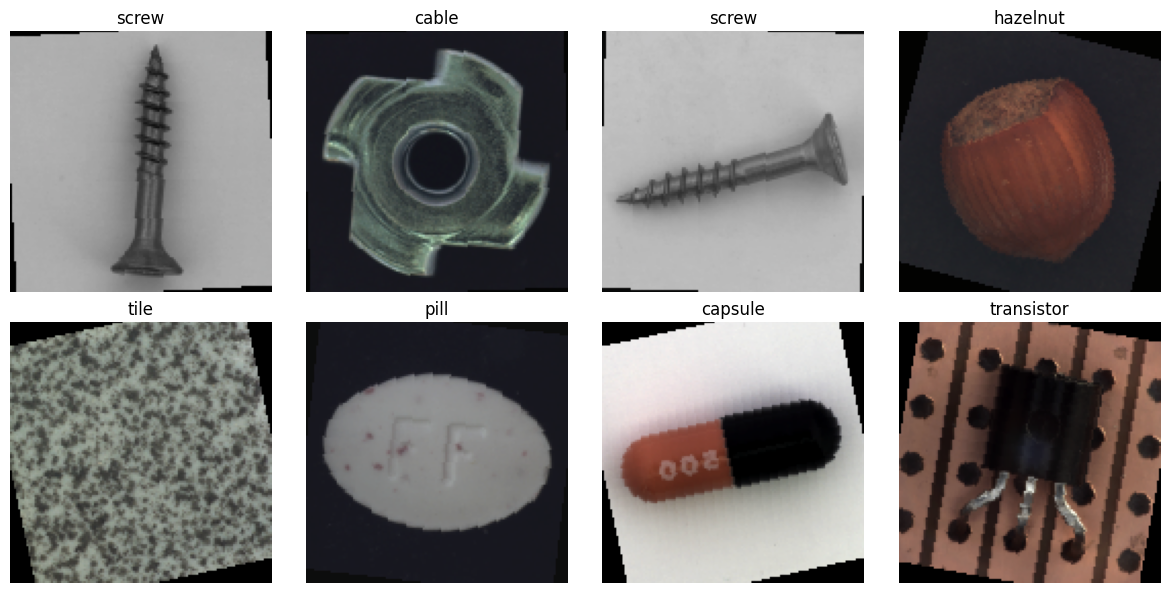

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

train_loader = datamodule.train_dataloader()
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        plt.sca(ax)
        class_name = cfg.class_names[labels[idx].item()]
        imshow(images[idx].cpu(), title=f"{class_name}")
plt.tight_layout()
plt.show()

### Funcion de entrenamiento

#### Entrenamiento Modelos ResNet - MVTec Anomaly Detection


In [27]:

import sys
import os
from pathlib import Path
import pytorch_lightning as pl
import numpy as np


def get_project_root():
    
    return Path(os.getcwd()).resolve()

project_root = get_project_root()


src_path = project_root / "src"
if src_path.exists():
    sys.path.insert(0, str(src_path))
else:
    sys.path.insert(0, str(project_root))

print("Project root:", project_root)
print("sys.path[0]:", sys.path[0])

# Import train_model (try both possibilities) and use the src package for datamodule

from train_model import train_model, load_trained_model, get_best_checkpoint_path


from src.data.mvtec_datamodule import MVTecDataModule

Project root: C:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\ProyectoAnomalias
sys.path[0]: C:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\ProyectoAnomalias\src


####  Cargar Configuración Base

In [28]:
from hydra import compose, initialize_config_dir
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

try:
    GlobalHydra.instance().clear()
except Exception:
    # safe fallback if GlobalHydra not initialized
    pass
# Inicializar Hydra con path absoluto
config_dir = str(project_root / "conf")
initialize_config_dir(config_dir=config_dir, version_base=None)

# Cargar config base
cfg = compose(config_name="config")


print("="*80)
print("CONFIGURACIÓN BASE")
print("="*80)
print(OmegaConf.to_yaml(cfg))

CONFIGURACIÓN BASE
model:
  loss:
    name: cross_entropy
    type: classification
    label_smoothing: 0.0
    weight: null
  optimizer:
    name: adam
    learning_rate: 0.001
    weight_decay: 0.0001
    betas:
    - 0.9
    - 0.999
    eps: 1.0e-08
    amsgrad: false
    scheduler:
      name: cosine
      enabled: true
      T_max: 100
      eta_min: 1.0e-06
  name: resnet_scratch
  type: scratch
  latent_dim: 128
  dropout: 0.3
  use_batch_norm: true
  learning_rate: 0.001
  weight_decay: 0.0001
  batch_size: 32
  max_epochs: 100
trainer:
  trainer: null
  accelerator: auto
  devices: 1
  precision: 32
  max_epochs: 100
logger:
  name: wandb
  project: mvtec-anomaly-detection
  entity: null
  save_dir: ./logs
  log_model: true
  log_gradients: false
  log_graph: false
  offline: false
  tags: []
  notes: null
loss:
  name: cross_entropy
  type: classification
  label_smoothing: 0.0
  weight: null
optimizer:
  name: adam
  learning_rate: 0.001
  weight_decay: 0.0001
  betas:
  - 0

#### Preparar DataModule

In [29]:
pl.seed_everything(cfg.seed)

# Crear DataModule
datamodule = MVTecDataModule(
    data_dir=cfg.data.data_dir,
    class_names=cfg.class_names, 
    batch_size=cfg.data.batch_size,
    num_workers=cfg.data.num_workers,
    image_size=cfg.data.image_size
)

datamodule.setup('fit')

print(f"\n📊 Dataset Cargado:")
print(f"  - Train: {len(datamodule.train_dataset)} imágenes")
print(f"  - Val: {len(datamodule.val_dataset)} imágenes")

Seed set to 42



📊 Dataset Cargado:
  - Train: 2072 imágenes
  - Val: 521 imágenes


### EXPERIMENTOS: ResNet Scratch

#### Experimento 1: Baseline (z=128, lr=1e-3, adam)

In [30]:
cfg_scratch_1 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "experiment.run_name=scratch_baseline_z128"
    ]
)

trainer_s1, model_s1 = train_model(
    cfg=cfg_scratch_1,
    datamodule=datamodule,
    model_type="scratch"
)


 Run Name: scratch_baseline_z128


wandb: Currently logged in as: c-vasquezashley (c-vasquezashley-tec) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3050 6GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\ProyectoAnomalias\checkpoints\scratch_baseline_z128 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | embedding_layer | Linear           | 65.7 K | train
1 | model           | ResNet           | 11.2 M |


 INICIANDO ENTRENAMIENTO: scratch_baseline_z128
 Modelo: resnet_scratch
 Latent Dim: 128
 Learning Rate: 0.001
  Optimizer: adam
 Scheduler: cosine
 Max Epochs: 100
 Batch Size: 32
 Loss: cross_entropy
 Checkpoint Dir: checkpoints\scratch_baseline_z128

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 64/64 [00:56<00:00,  1.13it/s, v_num=tyop, train/loss_step=0.171, val/loss=0.289, val/acc=0.919, train/loss_epoch=0.395, train/acc=0.903]

Metric val/loss improved. New best score: 0.289
Epoch 0, global step 64: 'val/loss' reached 0.28860 (best 0.28860), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=00-val/loss=0.2886.ckpt' as top 3


Epoch 1: 100%|██████████| 64/64 [00:09<00:00,  6.94it/s, v_num=tyop, train/loss_step=0.0536, val/loss=0.0157, val/acc=0.998, train/loss_epoch=0.172, train/acc=0.959]

Metric val/loss improved by 0.273 >= min_delta = 0.001. New best score: 0.016
Epoch 1, global step 128: 'val/loss' reached 0.01570 (best 0.01570), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=01-val/loss=0.0157.ckpt' as top 3


Epoch 2: 100%|██████████| 64/64 [00:08<00:00,  7.44it/s, v_num=tyop, train/loss_step=0.0128, val/loss=0.00389, val/acc=1.000, train/loss_epoch=0.0934, train/acc=0.985]

Metric val/loss improved by 0.012 >= min_delta = 0.001. New best score: 0.004
Epoch 2, global step 192: 'val/loss' reached 0.00389 (best 0.00389), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=02-val/loss=0.0039.ckpt' as top 3


Epoch 3: 100%|██████████| 64/64 [00:08<00:00,  7.26it/s, v_num=tyop, train/loss_step=0.837, val/loss=0.807, val/acc=0.800, train/loss_epoch=0.128, train/acc=0.971]     

Epoch 3, global step 256: 'val/loss' was not in top 3


Epoch 4: 100%|██████████| 64/64 [00:08<00:00,  7.48it/s, v_num=tyop, train/loss_step=0.00426, val/loss=0.00109, val/acc=1.000, train/loss_epoch=0.0503, train/acc=0.988]

Metric val/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.001
Epoch 4, global step 320: 'val/loss' reached 0.00109 (best 0.00109), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=04-val/loss=0.0011.ckpt' as top 3


Epoch 5: 100%|██████████| 64/64 [00:08<00:00,  7.32it/s, v_num=tyop, train/loss_step=0.0303, val/loss=0.532, val/acc=0.875, train/loss_epoch=0.0335, train/acc=0.993]   

Epoch 5, global step 384: 'val/loss' was not in top 3


Epoch 6: 100%|██████████| 64/64 [00:09<00:00,  6.87it/s, v_num=tyop, train/loss_step=0.079, val/loss=0.00414, val/acc=1.000, train/loss_epoch=0.0585, train/acc=0.986]

Epoch 6, global step 448: 'val/loss' reached 0.00414 (best 0.00109), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=06-val/loss=0.0041.ckpt' as top 3


Epoch 7: 100%|██████████| 64/64 [00:09<00:00,  6.90it/s, v_num=tyop, train/loss_step=0.00072, val/loss=0.0115, val/acc=0.998, train/loss_epoch=0.043, train/acc=0.992]  

Epoch 7, global step 512: 'val/loss' was not in top 3


Epoch 8: 100%|██████████| 64/64 [00:08<00:00,  7.35it/s, v_num=tyop, train/loss_step=0.00485, val/loss=0.000338, val/acc=1.000, train/loss_epoch=0.0513, train/acc=0.989]

Epoch 8, global step 576: 'val/loss' reached 0.00034 (best 0.00034), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=08-val/loss=0.0003.ckpt' as top 3


Epoch 9: 100%|██████████| 64/64 [00:08<00:00,  7.36it/s, v_num=tyop, train/loss_step=0.00165, val/loss=0.133, val/acc=0.916, train/loss_epoch=0.0281, train/acc=0.992]    

Epoch 9, global step 640: 'val/loss' was not in top 3


Epoch 10: 100%|██████████| 64/64 [00:08<00:00,  7.51it/s, v_num=tyop, train/loss_step=0.00409, val/loss=0.00495, val/acc=1.000, train/loss_epoch=0.0425, train/acc=0.987]

Epoch 10, global step 704: 'val/loss' was not in top 3


Epoch 11: 100%|██████████| 64/64 [00:08<00:00,  7.26it/s, v_num=tyop, train/loss_step=0.001, val/loss=0.000345, val/acc=1.000, train/loss_epoch=0.0177, train/acc=0.997]  

Epoch 11, global step 768: 'val/loss' reached 0.00035 (best 0.00034), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=11-val/loss=0.0003.ckpt' as top 3


Epoch 12: 100%|██████████| 64/64 [00:08<00:00,  7.33it/s, v_num=tyop, train/loss_step=0.0102, val/loss=6.79e-5, val/acc=1.000, train/loss_epoch=0.0101, train/acc=0.999]   

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.000
Epoch 12, global step 832: 'val/loss' reached 0.00007 (best 0.00007), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=12-val/loss=0.0001-v1.ckpt' as top 3


Epoch 13: 100%|██████████| 64/64 [00:08<00:00,  7.40it/s, v_num=tyop, train/loss_step=0.000432, val/loss=0.0472, val/acc=1.000, train/loss_epoch=0.0165, train/acc=0.997] 

Epoch 13, global step 896: 'val/loss' was not in top 3


Epoch 14: 100%|██████████| 64/64 [00:08<00:00,  7.47it/s, v_num=tyop, train/loss_step=0.000542, val/loss=0.00017, val/acc=1.000, train/loss_epoch=0.0206, train/acc=0.995]

Epoch 14, global step 960: 'val/loss' reached 0.00017 (best 0.00007), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=14-val/loss=0.0002.ckpt' as top 3


Epoch 15: 100%|██████████| 64/64 [00:08<00:00,  7.44it/s, v_num=tyop, train/loss_step=0.000452, val/loss=0.000846, val/acc=1.000, train/loss_epoch=0.0476, train/acc=0.989]

Epoch 15, global step 1024: 'val/loss' was not in top 3


Epoch 16: 100%|██████████| 64/64 [00:08<00:00,  7.42it/s, v_num=tyop, train/loss_step=0.00383, val/loss=7.75e-5, val/acc=1.000, train/loss_epoch=0.053, train/acc=0.986]   

Epoch 16, global step 1088: 'val/loss' reached 0.00008 (best 0.00007), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=16-val/loss=0.0001.ckpt' as top 3


Epoch 17: 100%|██████████| 64/64 [00:08<00:00,  7.39it/s, v_num=tyop, train/loss_step=0.000496, val/loss=0.000153, val/acc=1.000, train/loss_epoch=0.00416, train/acc=1.000]

Epoch 17, global step 1152: 'val/loss' reached 0.00015 (best 0.00007), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=17-val/loss=0.0002.ckpt' as top 3


Epoch 18: 100%|██████████| 64/64 [00:08<00:00,  7.39it/s, v_num=tyop, train/loss_step=0.000653, val/loss=4.25e-5, val/acc=1.000, train/loss_epoch=0.0071, train/acc=0.997]  

Epoch 18, global step 1216: 'val/loss' reached 0.00004 (best 0.00004), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=18-val/loss=0.0000-v1.ckpt' as top 3


Epoch 19: 100%|██████████| 64/64 [00:08<00:00,  7.24it/s, v_num=tyop, train/loss_step=0.000849, val/loss=0.000346, val/acc=1.000, train/loss_epoch=0.0182, train/acc=0.997]

Epoch 19, global step 1280: 'val/loss' was not in top 3


Epoch 20: 100%|██████████| 64/64 [00:08<00:00,  7.39it/s, v_num=tyop, train/loss_step=0.00883, val/loss=2.860, val/acc=0.691, train/loss_epoch=0.0186, train/acc=0.995]    

Epoch 20, global step 1344: 'val/loss' was not in top 3


Epoch 21: 100%|██████████| 64/64 [00:08<00:00,  7.42it/s, v_num=tyop, train/loss_step=0.00273, val/loss=0.000162, val/acc=1.000, train/loss_epoch=0.0458, train/acc=0.987]

Epoch 21, global step 1408: 'val/loss' was not in top 3


Epoch 22: 100%|██████████| 64/64 [00:08<00:00,  7.45it/s, v_num=tyop, train/loss_step=0.00273, val/loss=0.0377, val/acc=0.990, train/loss_epoch=0.0567, train/acc=0.992]   

Epoch 22, global step 1472: 'val/loss' was not in top 3


Epoch 23: 100%|██████████| 64/64 [00:08<00:00,  7.51it/s, v_num=tyop, train/loss_step=0.00505, val/loss=0.00078, val/acc=1.000, train/loss_epoch=0.020, train/acc=0.992] 

Epoch 23, global step 1536: 'val/loss' was not in top 3


Epoch 24: 100%|██████████| 64/64 [00:08<00:00,  7.41it/s, v_num=tyop, train/loss_step=0.108, val/loss=0.00289, val/acc=0.998, train/loss_epoch=0.0204, train/acc=0.991]  

Epoch 24, global step 1600: 'val/loss' was not in top 3


Epoch 25: 100%|██████████| 64/64 [00:08<00:00,  7.51it/s, v_num=tyop, train/loss_step=0.00472, val/loss=0.0015, val/acc=1.000, train/loss_epoch=0.0171, train/acc=0.995]  

Epoch 25, global step 1664: 'val/loss' was not in top 3


Epoch 26: 100%|██████████| 64/64 [00:08<00:00,  7.50it/s, v_num=tyop, train/loss_step=0.000564, val/loss=0.000208, val/acc=1.000, train/loss_epoch=0.0292, train/acc=0.994]

Epoch 26, global step 1728: 'val/loss' was not in top 3


Epoch 27: 100%|██████████| 64/64 [00:08<00:00,  7.48it/s, v_num=tyop, train/loss_step=0.000185, val/loss=2.98e-5, val/acc=1.000, train/loss_epoch=0.00417, train/acc=1.000]

Monitored metric val/loss did not improve in the last 15 records. Best score: 0.000. Signaling Trainer to stop.
Epoch 27, global step 1792: 'val/loss' reached 0.00003 (best 0.00003), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=27-val/loss=0.0000-v1.ckpt' as top 3


Epoch 27: 100%|██████████| 64/64 [00:09<00:00,  6.74it/s, v_num=tyop, train/loss_step=0.000185, val/loss=2.98e-5, val/acc=1.000, train/loss_epoch=0.00417, train/acc=1.000]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.



 ENTRENAMIENTO COMPLETADO
 Best checkpoint: C:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\ProyectoAnomalias\checkpoints\scratch_baseline_z128\best-epoch=27-val/loss=0.0000-v1.ckpt
 Best val_loss: 0.0000



epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
lr-Adam,████████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▁▁
train/acc,▁▅▇▆▇█▇▇▇▇▇████▇▇████▇▇▇▇███
train/loss_epoch,█▄▃▃▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▂▂▁▁▁▁▁
train/loss_step,▃▂▂▁▃▁▁▇▁▁▆▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▄▂▁▁▁▃▁▁▁
trainer/global_step,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val/acc,▆██▃█▅███▆██████████▁███████
val/loss,▂▁▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
epoch,27
lr-Adam,0.00083
train/acc,0.99951


### Experimento 2: Latent dim más grande (z=256)

In [31]:
cfg_scratch_2 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "model.latent_dim=256",
        "experiment.run_name=scratch_z256"
    ]
)

trainer_s2, model_s2 = train_model(
    cfg=cfg_scratch_2,
    datamodule=datamodule,
    model_type="scratch"
)


 Run Name: scratch_z256


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\ProyectoAnomalias\checkpoints\scratch_z256 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | embedding_layer | Linear           | 131 K  | train
1 | model           | ResNet           | 11.3 M | train
2 | criterion       | CrossEntropyLoss | 0      | train
-------------------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.244    Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode



 INICIANDO ENTRENAMIENTO: scratch_z256
 Modelo: resnet_scratch
 Latent Dim: 256
 Learning Rate: 0.001
  Optimizer: adam
 Scheduler: cosine
 Max Epochs: 100
 Batch Size: 32
 Loss: cross_entropy
 Checkpoint Dir: checkpoints\scratch_z256

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 64/64 [00:08<00:00,  7.31it/s, v_num=7zw5, train/loss_step=0.550, val/loss=0.769, val/acc=0.900, train/loss_epoch=0.485, train/acc=0.850]

Metric val/loss improved. New best score: 0.769
Epoch 0, global step 64: 'val/loss' reached 0.76850 (best 0.76850), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=00-val/loss=0.7685.ckpt' as top 3


Epoch 1: 100%|██████████| 64/64 [00:10<00:00,  5.95it/s, v_num=7zw5, train/loss_step=0.034, val/loss=0.003, val/acc=1.000, train/loss_epoch=0.141, train/acc=0.959]  

Metric val/loss improved by 0.766 >= min_delta = 0.001. New best score: 0.003
Epoch 1, global step 128: 'val/loss' reached 0.00300 (best 0.00300), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=01-val/loss=0.0030.ckpt' as top 3


Epoch 2: 100%|██████████| 64/64 [00:17<00:00,  3.70it/s, v_num=7zw5, train/loss_step=0.00868, val/loss=0.159, val/acc=0.937, train/loss_epoch=0.0634, train/acc=0.986]

Epoch 2, global step 192: 'val/loss' reached 0.15918 (best 0.00300), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=02-val/loss=0.1592.ckpt' as top 3


Epoch 3: 100%|██████████| 64/64 [00:11<00:00,  5.56it/s, v_num=7zw5, train/loss_step=0.282, val/loss=0.00312, val/acc=1.000, train/loss_epoch=0.0547, train/acc=0.983]

Epoch 3, global step 256: 'val/loss' reached 0.00312 (best 0.00300), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=03-val/loss=0.0031.ckpt' as top 3


Epoch 4: 100%|██████████| 64/64 [00:10<00:00,  6.33it/s, v_num=7zw5, train/loss_step=0.00729, val/loss=0.00298, val/acc=1.000, train/loss_epoch=0.0589, train/acc=0.986]

Epoch 4, global step 320: 'val/loss' reached 0.00298 (best 0.00298), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=04-val/loss=0.0030.ckpt' as top 3


Epoch 5: 100%|██████████| 64/64 [00:10<00:00,  6.05it/s, v_num=7zw5, train/loss_step=0.00201, val/loss=0.000567, val/acc=1.000, train/loss_epoch=0.0735, train/acc=0.984]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.001
Epoch 5, global step 384: 'val/loss' reached 0.00057 (best 0.00057), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=05-val/loss=0.0006.ckpt' as top 3


Epoch 6: 100%|██████████| 64/64 [00:09<00:00,  7.02it/s, v_num=7zw5, train/loss_step=0.0615, val/loss=0.0306, val/acc=0.990, train/loss_epoch=0.051, train/acc=0.986]     

Epoch 6, global step 448: 'val/loss' was not in top 3


Epoch 7: 100%|██████████| 64/64 [00:08<00:00,  7.39it/s, v_num=7zw5, train/loss_step=0.000293, val/loss=0.00016, val/acc=1.000, train/loss_epoch=0.0153, train/acc=0.997]

Epoch 7, global step 512: 'val/loss' reached 0.00016 (best 0.00016), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=07-val/loss=0.0002-v1.ckpt' as top 3


Epoch 8: 100%|██████████| 64/64 [00:08<00:00,  7.36it/s, v_num=7zw5, train/loss_step=0.00191, val/loss=0.0729, val/acc=0.969, train/loss_epoch=0.0164, train/acc=0.995]  

Epoch 8, global step 576: 'val/loss' was not in top 3


Epoch 9: 100%|██████████| 64/64 [00:08<00:00,  7.43it/s, v_num=7zw5, train/loss_step=0.0672, val/loss=0.000312, val/acc=1.000, train/loss_epoch=0.0903, train/acc=0.975]

Epoch 9, global step 640: 'val/loss' reached 0.00031 (best 0.00016), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=09-val/loss=0.0003.ckpt' as top 3


Epoch 10: 100%|██████████| 64/64 [00:08<00:00,  7.41it/s, v_num=7zw5, train/loss_step=0.00114, val/loss=0.000238, val/acc=1.000, train/loss_epoch=0.0392, train/acc=0.990] 

Epoch 10, global step 704: 'val/loss' reached 0.00024 (best 0.00016), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=10-val/loss=0.0002.ckpt' as top 3


Epoch 11: 100%|██████████| 64/64 [00:08<00:00,  7.38it/s, v_num=7zw5, train/loss_step=0.00851, val/loss=0.00311, val/acc=1.000, train/loss_epoch=0.039, train/acc=0.991]   

Epoch 11, global step 768: 'val/loss' was not in top 3


Epoch 12: 100%|██████████| 64/64 [00:08<00:00,  7.52it/s, v_num=7zw5, train/loss_step=0.000536, val/loss=0.000286, val/acc=1.000, train/loss_epoch=0.0226, train/acc=0.993]

Epoch 12, global step 832: 'val/loss' reached 0.00029 (best 0.00016), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=12-val/loss=0.0003.ckpt' as top 3


Epoch 13: 100%|██████████| 64/64 [00:08<00:00,  7.44it/s, v_num=7zw5, train/loss_step=0.000698, val/loss=0.000266, val/acc=1.000, train/loss_epoch=0.0177, train/acc=0.994]

Epoch 13, global step 896: 'val/loss' reached 0.00027 (best 0.00016), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=13-val/loss=0.0003.ckpt' as top 3


Epoch 14: 100%|██████████| 64/64 [00:08<00:00,  7.35it/s, v_num=7zw5, train/loss_step=0.114, val/loss=0.00183, val/acc=1.000, train/loss_epoch=0.0155, train/acc=0.998]    

Epoch 14, global step 960: 'val/loss' was not in top 3


Epoch 15: 100%|██████████| 64/64 [00:08<00:00,  7.50it/s, v_num=7zw5, train/loss_step=0.0478, val/loss=1.960, val/acc=0.745, train/loss_epoch=0.0101, train/acc=0.997]    

Epoch 15, global step 1024: 'val/loss' was not in top 3


Epoch 16: 100%|██████████| 64/64 [00:08<00:00,  7.45it/s, v_num=7zw5, train/loss_step=0.000878, val/loss=0.000519, val/acc=1.000, train/loss_epoch=0.0287, train/acc=0.994]

Epoch 16, global step 1088: 'val/loss' was not in top 3


Epoch 17: 100%|██████████| 64/64 [00:08<00:00,  7.40it/s, v_num=7zw5, train/loss_step=0.00373, val/loss=0.000273, val/acc=1.000, train/loss_epoch=0.0186, train/acc=0.997] 

Epoch 17, global step 1152: 'val/loss' was not in top 3


Epoch 18: 100%|██████████| 64/64 [00:08<00:00,  7.13it/s, v_num=7zw5, train/loss_step=0.000354, val/loss=5.89e-5, val/acc=1.000, train/loss_epoch=0.0129, train/acc=0.998] 

Epoch 18, global step 1216: 'val/loss' reached 0.00006 (best 0.00006), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=18-val/loss=0.0001-v1.ckpt' as top 3


Epoch 19: 100%|██████████| 64/64 [00:08<00:00,  7.47it/s, v_num=7zw5, train/loss_step=0.000886, val/loss=0.000179, val/acc=1.000, train/loss_epoch=0.00657, train/acc=0.998]

Epoch 19, global step 1280: 'val/loss' reached 0.00018 (best 0.00006), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=19-val/loss=0.0002-v1.ckpt' as top 3


Epoch 20: 100%|██████████| 64/64 [00:08<00:00,  7.34it/s, v_num=7zw5, train/loss_step=0.00295, val/loss=0.0149, val/acc=0.998, train/loss_epoch=0.0432, train/acc=0.993]    

Monitored metric val/loss did not improve in the last 15 records. Best score: 0.001. Signaling Trainer to stop.
Epoch 20, global step 1344: 'val/loss' was not in top 3


Epoch 20: 100%|██████████| 64/64 [00:09<00:00,  6.93it/s, v_num=7zw5, train/loss_step=0.00295, val/loss=0.0149, val/acc=0.998, train/loss_epoch=0.0432, train/acc=0.993]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.



 ENTRENAMIENTO COMPLETADO
 Best checkpoint: C:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\ProyectoAnomalias\checkpoints\scratch_z256\best-epoch=18-val/loss=0.0001-v1.ckpt
 Best val_loss: 0.0001



epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
lr-Adam,██████▇▇▇▇▆▆▅▅▅▄▃▃▂▂▁
train/acc,▁▆▇▇▇▇▇██▇███████████
train/loss_epoch,█▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂
train/loss_step,█▄▁▂▅▂▁▂▁▁▂▄▁▁▁▁▁▁▁▁▁▇▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
val/acc,▅█▆█████▇██████▁█████
val/loss,▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
epoch,20
lr-Adam,0.0009
train/acc,0.99268


### Experimento 3: Lower learning rate

In [ ]:
cfg_scratch_3 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "optimizer=adam_low",  # lr=1e-4
        "experiment.run_name=scratch_z128_lr1e-4"
    ]
)

trainer_s3, model_s3 = train_model(
    cfg=cfg_scratch_3,
    datamodule=datamodule,
    model_type="scratch"
)


 Run Name: scratch_z128_lr1e-4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\ProyectoAnomalias\checkpoints\scratch_z128_lr1e-4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 INICIANDO ENTRENAMIENTO: scratch_z128_lr1e-4
 Modelo: resnet_scratch
 Latent Dim: 128
 Learning Rate: 0.0001
  Optimizer: adam
 Scheduler: cosine
 Max Epochs: 100
 Batch Size: 32
 Loss: cross_entropy
 Checkpoint Dir: checkpoints\scratch_z128_lr1e-4




  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | embedding_layer | Linear           | 65.7 K | train
1 | model           | ResNet           | 11.2 M | train
2 | criterion       | CrossEntropyLoss | 0      | train
-------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.975    Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<?, ?it/s]

c:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 64/64 [00:08<00:00,  7.62it/s, v_num=1084, train/loss_step=0.146, val/loss=0.0351, val/acc=0.998, train/loss_epoch=0.752, train/acc=0.817]

Metric val/loss improved. New best score: 0.035
Epoch 0, global step 64: 'val/loss' reached 0.03506 (best 0.03506), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=00-val/loss=0.0351.ckpt' as top 3


Epoch 1: 100%|██████████| 64/64 [00:08<00:00,  7.68it/s, v_num=1084, train/loss_step=0.0999, val/loss=0.0168, val/acc=1.000, train/loss_epoch=0.0977, train/acc=0.994]

Metric val/loss improved by 0.018 >= min_delta = 0.001. New best score: 0.017
Epoch 1, global step 128: 'val/loss' reached 0.01681 (best 0.01681), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=01-val/loss=0.0168.ckpt' as top 3


Epoch 2: 100%|██████████| 64/64 [00:08<00:00,  7.63it/s, v_num=1084, train/loss_step=0.016, val/loss=0.00928, val/acc=1.000, train/loss_epoch=0.0389, train/acc=0.998]

Metric val/loss improved by 0.008 >= min_delta = 0.001. New best score: 0.009
Epoch 2, global step 192: 'val/loss' reached 0.00928 (best 0.00928), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=02-val/loss=0.0093.ckpt' as top 3


Epoch 3: 100%|██████████| 64/64 [00:08<00:00,  7.61it/s, v_num=1084, train/loss_step=0.0198, val/loss=0.00687, val/acc=1.000, train/loss_epoch=0.0357, train/acc=0.996]

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.007
Epoch 3, global step 256: 'val/loss' reached 0.00687 (best 0.00687), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=03-val/loss=0.0069.ckpt' as top 3


Epoch 4: 100%|██████████| 64/64 [00:08<00:00,  7.17it/s, v_num=1084, train/loss_step=0.0106, val/loss=0.00484, val/acc=1.000, train/loss_epoch=0.016, train/acc=1.000]  

Metric val/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.005
Epoch 4, global step 320: 'val/loss' reached 0.00484 (best 0.00484), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=04-val/loss=0.0048.ckpt' as top 3


Epoch 5: 100%|██████████| 64/64 [00:09<00:00,  6.65it/s, v_num=1084, train/loss_step=0.0507, val/loss=0.0106, val/acc=0.998, train/loss_epoch=0.0252, train/acc=0.996] 

Epoch 5, global step 384: 'val/loss' was not in top 3


Epoch 6: 100%|██████████| 64/64 [00:08<00:00,  7.41it/s, v_num=1084, train/loss_step=0.00639, val/loss=0.00336, val/acc=1.000, train/loss_epoch=0.00984, train/acc=1.000]

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Epoch 6, global step 448: 'val/loss' reached 0.00336 (best 0.00336), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=06-val/loss=0.0034.ckpt' as top 3


Epoch 7: 100%|██████████| 64/64 [00:08<00:00,  7.29it/s, v_num=1084, train/loss_step=0.00665, val/loss=0.00265, val/acc=1.000, train/loss_epoch=0.00905, train/acc=1.000]

Epoch 7, global step 512: 'val/loss' reached 0.00265 (best 0.00265), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=07-val/loss=0.0026.ckpt' as top 3


Epoch 8: 100%|██████████| 64/64 [00:10<00:00,  6.13it/s, v_num=1084, train/loss_step=0.011, val/loss=0.0022, val/acc=1.000, train/loss_epoch=0.00585, train/acc=1.000]   

Metric val/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Epoch 8, global step 576: 'val/loss' reached 0.00220 (best 0.00220), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=08-val/loss=0.0022.ckpt' as top 3


Epoch 9: 100%|██████████| 64/64 [00:11<00:00,  5.70it/s, v_num=1084, train/loss_step=0.00504, val/loss=0.00194, val/acc=1.000, train/loss_epoch=0.00476, train/acc=1.000]

Epoch 9, global step 640: 'val/loss' reached 0.00194 (best 0.00194), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=09-val/loss=0.0019.ckpt' as top 3


Epoch 10: 100%|██████████| 64/64 [00:09<00:00,  7.02it/s, v_num=1084, train/loss_step=0.00339, val/loss=0.00174, val/acc=1.000, train/loss_epoch=0.0042, train/acc=1.000] 

Epoch 10, global step 704: 'val/loss' reached 0.00174 (best 0.00174), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=10-val/loss=0.0017.ckpt' as top 3


### Experimento 4: AdamW optimizer

In [ ]:
cfg_scratch_4 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "optimizer=adamw",
        "experiment.run_name=scratch_z128_adamw"
    ]
)

trainer_s4, model_s4 = train_model(
    cfg=cfg_scratch_4,
    datamodule=datamodule,
    model_type="scratch"
)


 Run Name: scratch_z128_adamw


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 INICIANDO ENTRENAMIENTO: scratch_z128_adamw
 Modelo: resnet_scratch
 Latent Dim: 128
 Learning Rate: 0.001
  Optimizer: adamw
 Scheduler: cosine
 Max Epochs: 100
 Batch Size: 32
 Loss: cross_entropy
 Checkpoint Dir: checkpoints\scratch_z128_adamw




  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | embedding_layer | Linear           | 65.7 K | train
1 | model           | ResNet           | 11.2 M | train
2 | criterion       | CrossEntropyLoss | 0      | train
-------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.975    Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 141.98it/s]

c:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 64/64 [00:09<00:00,  6.49it/s, v_num=4ioy, train/loss_step=0.0949, val/loss=0.0383, val/acc=1.000, train/loss_epoch=0.411, train/acc=0.890]

Metric val/loss improved. New best score: 0.038
Epoch 0, global step 64: 'val/loss' reached 0.03832 (best 0.03832), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=00-val/loss=0.0383.ckpt' as top 3


Epoch 1: 100%|██████████| 64/64 [00:10<00:00,  6.36it/s, v_num=4ioy, train/loss_step=0.0128, val/loss=0.00342, val/acc=1.000, train/loss_epoch=0.0829, train/acc=0.982]

Metric val/loss improved by 0.035 >= min_delta = 0.001. New best score: 0.003
Epoch 1, global step 128: 'val/loss' reached 0.00342 (best 0.00342), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=01-val/loss=0.0034.ckpt' as top 3


Epoch 2: 100%|██████████| 64/64 [00:12<00:00,  5.32it/s, v_num=4ioy, train/loss_step=0.0962, val/loss=0.0108, val/acc=0.998, train/loss_epoch=0.102, train/acc=0.977]   

Epoch 2, global step 192: 'val/loss' reached 0.01077 (best 0.00342), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=02-val/loss=0.0108.ckpt' as top 3


Epoch 3: 100%|██████████| 64/64 [00:09<00:00,  6.71it/s, v_num=4ioy, train/loss_step=0.0561, val/loss=0.0555, val/acc=0.988, train/loss_epoch=0.0778, train/acc=0.980]

Epoch 3, global step 256: 'val/loss' was not in top 3


Epoch 4: 100%|██████████| 64/64 [00:08<00:00,  7.37it/s, v_num=4ioy, train/loss_step=0.00354, val/loss=0.00453, val/acc=1.000, train/loss_epoch=0.0941, train/acc=0.981]

Epoch 4, global step 320: 'val/loss' reached 0.00453 (best 0.00342), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=04-val/loss=0.0045.ckpt' as top 3


Epoch 5: 100%|██████████| 64/64 [00:08<00:00,  7.55it/s, v_num=4ioy, train/loss_step=0.431, val/loss=0.671, val/acc=0.877, train/loss_epoch=0.0429, train/acc=0.990]     

Epoch 5, global step 384: 'val/loss' was not in top 3


Epoch 6: 100%|██████████| 64/64 [00:08<00:00,  7.77it/s, v_num=4ioy, train/loss_step=0.0072, val/loss=0.105, val/acc=0.902, train/loss_epoch=0.0356, train/acc=0.991]  

Epoch 6, global step 448: 'val/loss' was not in top 3


Epoch 7: 100%|██████████| 64/64 [00:08<00:00,  7.72it/s, v_num=4ioy, train/loss_step=0.00264, val/loss=0.000327, val/acc=1.000, train/loss_epoch=0.0609, train/acc=0.986]

Metric val/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.000
Epoch 7, global step 512: 'val/loss' reached 0.00033 (best 0.00033), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=07-val/loss=0.0003.ckpt' as top 3


Epoch 8: 100%|██████████| 64/64 [00:08<00:00,  7.48it/s, v_num=4ioy, train/loss_step=0.00159, val/loss=0.00607, val/acc=1.000, train/loss_epoch=0.0204, train/acc=0.996]  

Epoch 8, global step 576: 'val/loss' was not in top 3


Epoch 9: 100%|██████████| 64/64 [00:08<00:00,  7.68it/s, v_num=4ioy, train/loss_step=0.00375, val/loss=0.000284, val/acc=1.000, train/loss_epoch=0.00378, train/acc=0.999]

Epoch 9, global step 640: 'val/loss' reached 0.00028 (best 0.00028), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=09-val/loss=0.0003.ckpt' as top 3


Epoch 10: 100%|██████████| 64/64 [00:08<00:00,  7.65it/s, v_num=4ioy, train/loss_step=0.000682, val/loss=5.9e-5, val/acc=1.000, train/loss_epoch=0.0185, train/acc=0.997]   

Epoch 10, global step 704: 'val/loss' reached 0.00006 (best 0.00006), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=10-val/loss=0.0001.ckpt' as top 3


Epoch 11: 100%|██████████| 64/64 [00:08<00:00,  7.43it/s, v_num=4ioy, train/loss_step=0.000115, val/loss=2.86e-5, val/acc=1.000, train/loss_epoch=0.00867, train/acc=0.998]

Epoch 11, global step 768: 'val/loss' reached 0.00003 (best 0.00003), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=11-val/loss=0.0000.ckpt' as top 3


Epoch 12: 100%|██████████| 64/64 [00:08<00:00,  7.66it/s, v_num=4ioy, train/loss_step=0.00015, val/loss=2.56e-5, val/acc=1.000, train/loss_epoch=0.00569, train/acc=0.999] 

Epoch 12, global step 832: 'val/loss' reached 0.00003 (best 0.00003), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=12-val/loss=0.0000.ckpt' as top 3


Epoch 13: 100%|██████████| 64/64 [00:08<00:00,  7.71it/s, v_num=4ioy, train/loss_step=0.000379, val/loss=2.58e-5, val/acc=1.000, train/loss_epoch=0.00642, train/acc=0.999]

Epoch 13, global step 896: 'val/loss' reached 0.00003 (best 0.00003), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=13-val/loss=0.0000.ckpt' as top 3


Epoch 14: 100%|██████████| 64/64 [00:08<00:00,  7.29it/s, v_num=4ioy, train/loss_step=0.00012, val/loss=1.64e-5, val/acc=1.000, train/loss_epoch=0.00246, train/acc=1.000] 

Epoch 14, global step 960: 'val/loss' reached 0.00002 (best 0.00002), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=14-val/loss=0.0000.ckpt' as top 3


Epoch 15: 100%|██████████| 64/64 [00:10<00:00,  6.27it/s, v_num=4ioy, train/loss_step=0.0012, val/loss=1.99e-5, val/acc=1.000, train/loss_epoch=0.0111, train/acc=0.998]   

Epoch 15, global step 1024: 'val/loss' reached 0.00002 (best 0.00002), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=15-val/loss=0.0000.ckpt' as top 3


Epoch 16: 100%|██████████| 64/64 [00:08<00:00,  7.12it/s, v_num=4ioy, train/loss_step=0.00111, val/loss=1.42e-5, val/acc=1.000, train/loss_epoch=0.000405, train/acc=1.000]

Epoch 16, global step 1088: 'val/loss' reached 0.00001 (best 0.00001), saving model to 'C:\\Users\\OS\\Desktop\\TEC\\IIS-2025\\IA\\ProyectoFinal\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=16-val/loss=0.0000.ckpt' as top 3


Epoch 17: 100%|██████████| 64/64 [00:08<00:00,  7.49it/s, v_num=4ioy, train/loss_step=0.000168, val/loss=0.014, val/acc=0.998, train/loss_epoch=0.0196, train/acc=0.997]    

Epoch 17, global step 1152: 'val/loss' was not in top 3


Epoch 18: 100%|██████████| 64/64 [00:08<00:00,  7.57it/s, v_num=4ioy, train/loss_step=0.000409, val/loss=3.54e-5, val/acc=1.000, train/loss_epoch=0.0278, train/acc=0.993]

Epoch 18, global step 1216: 'val/loss' was not in top 3


Epoch 19: 100%|██████████| 64/64 [00:08<00:00,  7.58it/s, v_num=4ioy, train/loss_step=0.00245, val/loss=0.00226, val/acc=1.000, train/loss_epoch=0.0378, train/acc=0.992] 

Epoch 19, global step 1280: 'val/loss' was not in top 3


Epoch 20: 100%|██████████| 64/64 [00:08<00:00,  7.54it/s, v_num=4ioy, train/loss_step=0.000278, val/loss=0.000323, val/acc=1.000, train/loss_epoch=0.0483, train/acc=0.991]

Epoch 20, global step 1344: 'val/loss' was not in top 3


Epoch 21: 100%|██████████| 64/64 [00:08<00:00,  7.62it/s, v_num=4ioy, train/loss_step=0.000811, val/loss=4.62e-5, val/acc=1.000, train/loss_epoch=0.0163, train/acc=0.996] 

Epoch 21, global step 1408: 'val/loss' was not in top 3


Epoch 22: 100%|██████████| 64/64 [00:08<00:00,  7.62it/s, v_num=4ioy, train/loss_step=0.00196, val/loss=6.19e-5, val/acc=1.000, train/loss_epoch=0.0318, train/acc=0.993] 

Monitored metric val/loss did not improve in the last 15 records. Best score: 0.000. Signaling Trainer to stop.
Epoch 22, global step 1472: 'val/loss' was not in top 3


Epoch 22: 100%|██████████| 64/64 [00:08<00:00,  7.18it/s, v_num=4ioy, train/loss_step=0.00196, val/loss=6.19e-5, val/acc=1.000, train/loss_epoch=0.0318, train/acc=0.993]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.



 ENTRENAMIENTO COMPLETADO
 Best checkpoint: C:\Users\OS\Desktop\TEC\IIS-2025\IA\ProyectoFinal\ProyectoAnomalias\checkpoints\scratch_z128_adamw\best-epoch=16-val/loss=0.0000.ckpt
 Best val_loss: 0.0000



epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇████
lr-AdamW,██████▇▇▇▇▇▆▆▅▅▅▄▄▃▃▂▂▁
train/acc,▁▇▇▇▇▇▇▇███████████▇▇██
train/loss_epoch,█▂▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂
train/loss_step,█▄▁▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
val/acc,███▇█▁▂████████████████
val/loss,▁▁▁▂▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,22
lr-AdamW,0.00089
train/acc,0.99316


##  ResNet Distilled

### Distillation v1 (T=3, α=0.5)

In [ ]:
cfg_dist_1 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "loss=distillation_v1",
        "experiment.run_name=distilled_v1_T3_a05"
    ]
)

trainer_d1, model_d1 = train_model(
    cfg=cfg_dist_1,
    datamodule=datamodule,
    model_type="distilled"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



 Run Name: distilled_v1_T3_a05

 INICIANDO ENTRENAMIENTO: distilled_v1_T3_a05
 Modelo: distilled
 Latent Dim: 128
 Learning Rate: 0.001
  Optimizer: adam
 Scheduler: cosine
 Max Epochs: 100
 Batch Size: 32
 Loss: distillation_v1 (T=3.0, α=0.5, β=0.3)
 Checkpoint Dir: checkpoints\distilled_v1_T3_a05




  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | teacher         | ResNet           | 11.2 M | eval 
1 | embedding_layer | Linear           | 65.7 K | train
2 | student         | ResNet           | 11.2 M | train
3 | hard_loss       | CrossEntropyLoss | 0      | train
4 | soft_loss       | KLDivLoss        | 0      | train
5 | feature_loss    | MSELoss          | 0      | train
-------------------------------------------------------------
11.2 M    Trainable params
11.2 M    Non-trainable params
22.4 M    Total params
89.701    Total estimated model params size (MB)
77        Modules in train mode
68        Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (128) must match the size of tensor b (512) at non-singleton dimension 1

### Distillation v2 (T=5, α=0.3, β=0.5)

In [ ]:
cfg_dist_2 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "loss=distillation_v2",
        "experiment.run_name=distilled_v2_T5_a03_b05"
    ]
)

trainer_d2, model_d2 = train_model(
    cfg=cfg_dist_2,
    datamodule=datamodule,
    model_type="distilled"
)

### Distillation v3 (T=7, balanceado)

In [ ]:
cfg_dist_3 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "loss=distillation_v3",
        "experiment.run_name=distilled_v3_T7_balanced"
    ]
)

trainer_d3, model_d3 = train_model(
    cfg=cfg_dist_3,
    datamodule=datamodule,
    model_type="distilled"
)

### Distilled con z=256

In [ ]:
cfg_dist_4 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "model.latent_dim=256",
        "loss=distillation_v2",
        "experiment.run_name=distilled_z256_v2"
    ]
)

trainer_d4, model_d4 = train_model(
    cfg=cfg_dist_4,
    datamodule=datamodule,
    model_type="distilled"
)

## Comparar Resultados
---

In [ ]:
import pandas as pd

# Recopilar resultados
results = []

experiments = [
    ("scratch_baseline_z128", "scratch", trainer_s1),
    ("scratch_z256", "scratch", trainer_s2),
    ("scratch_z128_lr1e-4", "scratch", trainer_s3),
    ("scratch_z128_adamw", "scratch", trainer_s4),
    ("distilled_v1_T3_a05", "distilled", trainer_d1),
    ("distilled_v2_T5_a03_b05", "distilled", trainer_d2),
    ("distilled_v3_T7_balanced", "distilled", trainer_d3),
    ("distilled_z256_v2", "distilled", trainer_d4),
]

for name, model_type, trainer in experiments:
    results.append({
        'experiment': name,
        'type': model_type,
        'best_val_loss': trainer.checkpoint_callback.best_model_score.item(),
        'checkpoint': trainer.checkpoint_callback.best_model_path
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('best_val_loss')

print("\n" + "="*80)
print(" RESUMEN DE EXPERIMENTOS")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

### Evaluar Mejores Modelos en Test Set

In [ ]:
datamodule.setup('test')

top3_experiments = df_results.head(3)

test_results = []

for _, row in top3_experiments.iterrows():
    print(f"\n{'='*80}")
    print(f"Testing: {row['experiment']}")
    print(f"{'='*80}")
    
    # Cargar modelo
    model = load_trained_model(row['checkpoint'], row['type'])
    
    # Evaluar
    trainer = pl.Trainer(accelerator='auto', devices=1)
    result = trainer.test(model, datamodule)
    
    test_results.append({
        'experiment': row['experiment'],
        'val_loss': row['best_val_loss'],
        'test_acc': result[0]['test/acc']
    })

df_test = pd.DataFrame(test_results)
print("\n" + "="*80)
print(" RESULTADOS EN TEST SET")
print("="*80)
print(df_test.to_string(index=False))
print("="*80)

### Extraer Embeddings para Anomaly Detection

In [ ]:
# Usar el mejor modelo
best_exp = df_results.iloc[0]
best_model_path = best_exp['checkpoint']
best_model_type = best_exp['type']
best_run_name = best_exp['experiment']

print(f"\n Mejor modelo: {best_run_name}")
print(f"   Val Loss: {best_exp['best_val_loss']:.4f}")

# Cargar
best_model = load_trained_model(best_model_path, best_model_type)

### Extraer embeddings de Validation

In [ ]:
datamodule.setup('fit')
val_loader = datamodule.val_dataloader()

print("Extrayendo embeddings de validación...")
val_embeddings, val_labels = best_model.extract_embeddings_from_dataloader(val_loader)

print(f"\n Validation Embeddings:")
print(f"   Shape: {val_embeddings.shape}")
print(f"   Labels: {val_labels.shape}")

# Guardar
embeddings_dir = project_root / "embeddings"
embeddings_dir.mkdir(exist_ok=True)

np.save(embeddings_dir / f"{best_run_name}_val_embeddings.npy", val_embeddings)
np.save(embeddings_dir / f"{best_run_name}_val_labels.npy", val_labels)

print(f" Guardado en: {embeddings_dir}")

### Extraer embeddings de Test

In [ ]:
print("Extrayendo embeddings de test...")
test_embeddings, test_labels = best_model.extract_embeddings_from_dataloader(test_loader)

print(f"\n Test Embeddings:")
print(f"   Shape: {test_embeddings.shape}")
print(f"   Labels: {test_labels.shape}")
print(f"   Normal: {(test_labels == 0).sum()}")
print(f"   Anomaly: {(test_labels == 1).sum()}")

np.save(embeddings_dir / f"{best_run_name}_test_embeddings.npy", test_embeddings)
np.save(embeddings_dir / f"{best_run_name}_test_labels.npy", test_labels)

print(f" Guardado en: {embeddings_dir}")

# Analisis Final

In [ ]:
import matplotlib.pyplot as plt

# Comparar Scratch vs Distilled
scratch_losses = df_results[df_results['type'] == 'scratch']['best_val_loss']
distilled_losses = df_results[df_results['type'] == 'distilled']['best_val_loss']

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([scratch_losses, distilled_losses], labels=['Scratch', 'Distilled'])
ax.set_ylabel('Best Validation Loss')
ax.set_title('Comparison: Scratch vs Distilled Models')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('scratch_vs_distilled_comparison.png', dpi=150)
plt.show()

print(f"\n📊 Scratch - Mean Val Loss: {scratch_losses.mean():.4f} ± {scratch_losses.std():.4f}")
print(f"📊 Distilled - Mean Val Loss: {distilled_losses.mean():.4f} ± {distilled_losses.std():.4f}")
